# Melanoma_Detection_Assignment


**Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2

model = models.Sequential

import os
import PIL

import pathlib
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Reading Training and Testing Data

In [ ]:
batch_size = 32
epochs = 20
input_image_height = 180
input_image_width = 180

#/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration
training_data_dir = '/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
testing_data_dir = '/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'


In [ ]:
data_dir_train = pathlib.Path(training_data_dir)
data_dir_test  = pathlib.Path(testing_data_dir)

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total images in training directory:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in testing directory:", image_count_test)

Total images in training directory: 2239
Total images in testing directory: 118


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#print('Image per batch:', len(list(train_ds.as_numpy_iterator())))
print('Images in Train:', len(train_ds.file_paths))
print('Images in Validation:', len(val_ds.file_paths))

Images in Train: 1792
Images in Validation: 447


In [ ]:
class_names = train_ds.class_names
print('The Class Names are: ', class_names)

The Class Names are:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 2. Visualizing the data

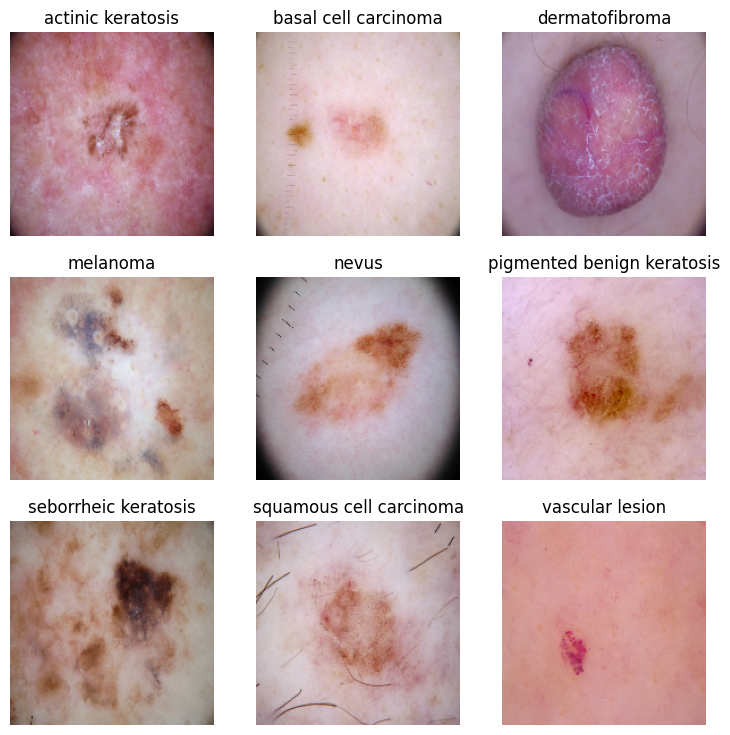

In [ ]:
i = 0
fig = plt.figure(figsize=(9,9))
for ind in range(len(class_names)):
    for img, lab in train_ds:
        #print(np.argmax(lab, axis=1)[0])
        if(np.argmax(lab, axis=1)[0] == ind):
        #if(lab[0] == ind):
            image = img
            break
    i = i + 1
    ax = plt.subplot(3, 3, i)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[ind])
    plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Create a Model & Training


#### 3.1. Training using Model 1

In [ ]:
def visualize_outputs(fit_data):
    acc = fit_data.history['accuracy']
    val_acc = fit_data.history['val_accuracy']

    loss = fit_data.history['loss']
    val_loss = fit_data.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1./255, input_shape=(input_image_height, input_image_width, 3)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Flatten())
    model.add(Dropout(0.15))
    #model.add(Dense(128, kernel_regularizer=l2(0.01)))
    #model.add(Dense(128))
    #model.add(Activation('relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(len(class_names), activation='softmax'))
    return model

In [ ]:
model_1 = get_model()
model_1.build(train_ds.as_numpy_iterator().next()[0].shape)

In [ ]:
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 179, 179, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 178, 178, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      1

In [ ]:
### Todo, choose an appropirate optimiser and loss function
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=1e-6)
model_1.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
hist = model_1.fit(train_ds, epochs = epochs, validation_data=val_ds)


Epoch 1/20
56/56 [==============================] - 27s 291ms/step - loss: 2.0583 - accuracy: 0.1920 - val_loss: 1.9942 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 10s 185ms/step - loss: 1.9895 - accuracy: 0.2489 - val_loss: 1.9971 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 10s 186ms/step - loss: 1.9730 - accuracy: 0.2506 - val_loss: 1.9966 - val_accuracy: 0.2394
Epoch 4/20
56/56 [==============================] - 10s 187ms/step - loss: 1.8658 - accuracy: 0.3220 - val_loss: 2.0386 - val_accuracy: 0.2506
Epoch 5/20
56/56 [==============================] - 11s 188ms/step - loss: 1.7876 - accuracy: 0.3577 - val_loss: 1.6292 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 11s 188ms/step - loss: 1.7322 - accuracy: 0.3917 - val_loss: 1.5893 - val_accuracy: 0.4430
Epoch 7/20
56/56 [==============================] - 10s 185ms/step - loss: 1.6800 - accuracy: 0.3917 - val_loss: 2.0243 - val_accuracy: 0.2707

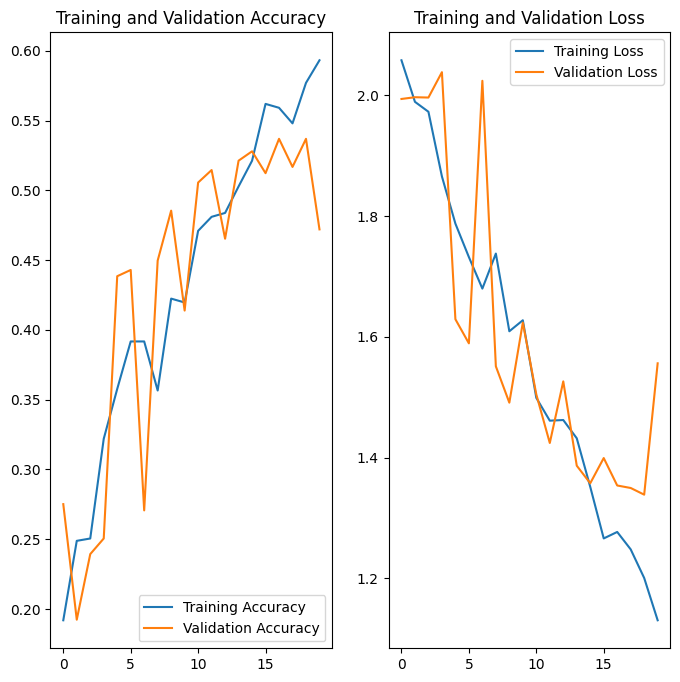

In [ ]:
visualize_outputs(hist)

##### Observations

- There is a significant difference between the training accuracy and the validation accuracy on higher epochs.
- Also, the error rate has also increased for the validation data.
- This could be a reason for overfitting.
- Also, the training accuracy is not high enough. This can be due to less amount of data to learn. To increase the training samples, we will augment the data.
- Augmentation tries to randomly flip/rotate/zoom the images and add them as new images.
- These can help model learn better...

## 4. Handle Overfitting using Augmentation


In [ ]:
path_list_old = list(data_dir_train.glob('*/*.jpg'))
print("Existing Images Count:", len(path_list_old))

lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in path_list_old]
print(set(lesion_list_old), " Categories of Existing Generated Image files:",  len(lesion_list_old))

dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

df_old = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

Existing Images Count: 2239
{'actinic keratosis', 'dermatofibroma', 'basal cell carcinoma', 'melanoma', 'seborrheic keratosis', 'nevus', 'vascular lesion', 'pigmented benign keratosis', 'squamous cell carcinoma'}  Categories of Existing Generated Image files: 2239


<BarContainer object of 9 artists>

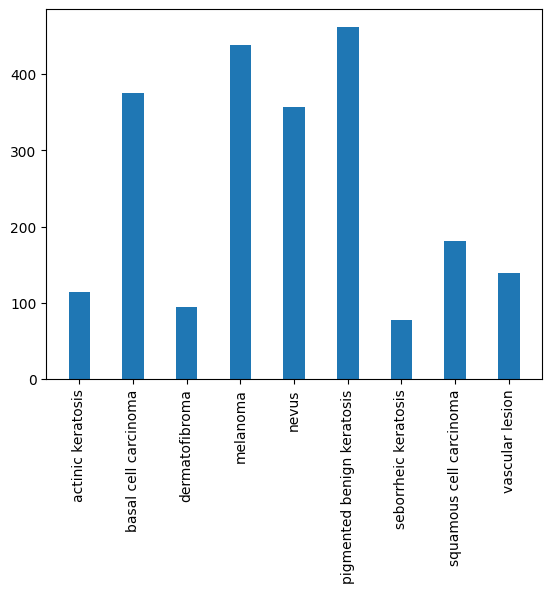

In [ ]:
data_old = df_old.groupby(by='Label').agg('count')
data_old['Label'] = data_old.index
plt.xticks(rotation=90)
plt.bar(data_old['Label'], data_old['Path'], width=0.4)

In [ ]:
!pip install Augmentor
import Augmentor

### 4.1 Prepare Augmentor Layers


*   Random flip
*   Skew
*   Random Zoom
*   Random Distortion
*   Rotate



In [ ]:
for each_class in class_names:
    print("Working with class: ", each_class)
    augmentor = Augmentor.Pipeline(training_data_dir + each_class)
    augmentor.flip_random(probability=0.39)
    augmentor.skew(probability=0.17)
    augmentor.zoom_random(probability=0.17, percentage_area=0.11)
    augmentor.random_distortion(probability=0.31, grid_width=input_image_width, grid_height=input_image_height, magnitude=1)
    augmentor.rotate(probability=0.13, max_left_rotation=10, max_right_rotation=12)
    augmentor.sample(500)

Working with class:  actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BC75E35B8B0>: 100%|██████████| 500/500 [02:43<00:00,  3.06 Samples/s]


Working with class:  basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BC7C02C34C0>: 100%|██████████| 500/500 [02:15<00:00,  3.70 Samples/s]


Working with class:  dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BC7C19369B0>: 100%|██████████| 500/500 [02:24<00:00,  3.45 Samples/s]


Working with class:  melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7BC75E31A9E0>: 100%|██████████| 500/500 [03:21<00:00,  2.49 Samples/s]


Working with class:  nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x671 at 0x7BC7C0156E30>: 100%|██████████| 500/500 [03:16<00:00,  2.54 Samples/s]


Working with class:  pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BC78B9F2560>: 100%|██████████| 500/500 [02:25<00:00,  3.44 Samples/s]


Working with class:  seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BC7C1AE27D0>: 100%|██████████| 500/500 [02:50<00:00,  2.93 Samples/s]


Working with class:  squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BC7C0154520>: 100%|██████████| 500/500 [02:18<00:00,  3.60 Samples/s]


Working with class:  vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BC7C0298580>: 100%|██████████| 500/500 [02:23<00:00,  3.49 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list_new = list(data_dir_train.glob('*/output/*.jpg'))
print("Newly Generated Images Count:", len(path_list_new))

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]
print(set(lesion_list_new), " Categories of Newly Generated Images:", len(lesion_list_new))

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

Newly Generated Images Count: 4500
{'actinic keratosis', 'dermatofibroma', 'basal cell carcinoma', 'melanoma', 'seborrheic keratosis', 'nevus', 'vascular lesion', 'pigmented benign keratosis', 'squamous cell carcinoma'}  Categories of Newly Generated Images: 4500


In [ ]:
#[os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]

<BarContainer object of 9 artists>

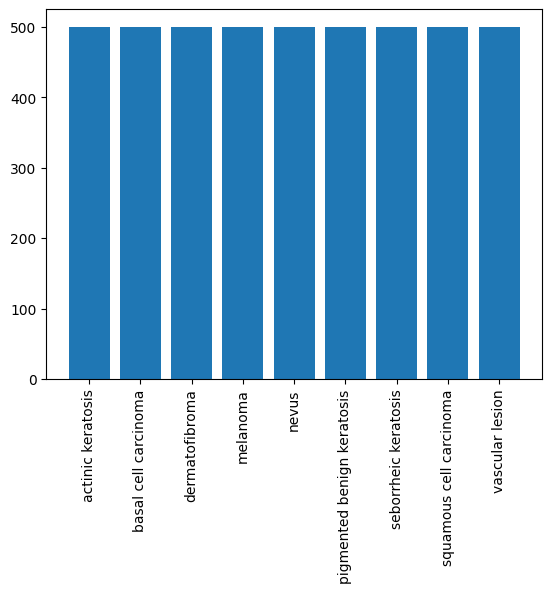

In [ ]:
data_new = df_new.groupby(by='Label').agg('count')
data_new['Label'] = data_new.index
plt.xticks(rotation=90)
plt.bar(data_new['Label'], data_new['Path'], width=0.8)

In [ ]:
new_images_parent_path = pd.DataFrame([[os.path.basename(os.path.dirname(os.path.dirname(y))), os.path.dirname(y) ] for y in path_list_new], columns=('class_name', 'directory_path')).drop_duplicates()
new_images_parent_path.directory_path[0]

'/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output'

In [ ]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in path_list_old]
print(set(lesion_list_old), " Categories of Existing Generated Image files:",  len(lesion_list_old))

{'actinic keratosis', 'dermatofibroma', 'basal cell carcinoma', 'melanoma', 'seborrheic keratosis', 'nevus', 'vascular lesion', 'pigmented benign keratosis', 'squamous cell carcinoma'}  Categories of Existing Generated Image files: 2239


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))


df_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_old = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

consolidated_df =pd.concat([df_new, df_old])

consolidated_df['Label'].value_counts()


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

<BarContainer object of 9 artists>

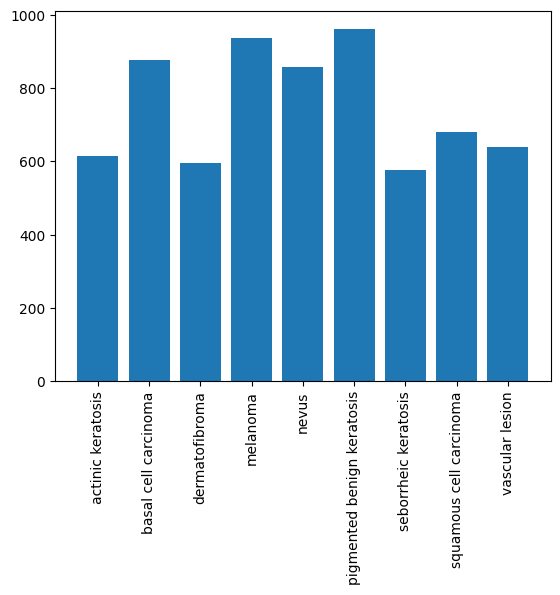

In [ ]:
data_consolidated = consolidated_df.groupby(by='Label').agg('count')
data_consolidated['Label'] = data_consolidated.index
plt.xticks(rotation=90)
plt.bar(data_consolidated['Label'], data_consolidated['Path'], width=0.8)

<BarContainer object of 9 artists>

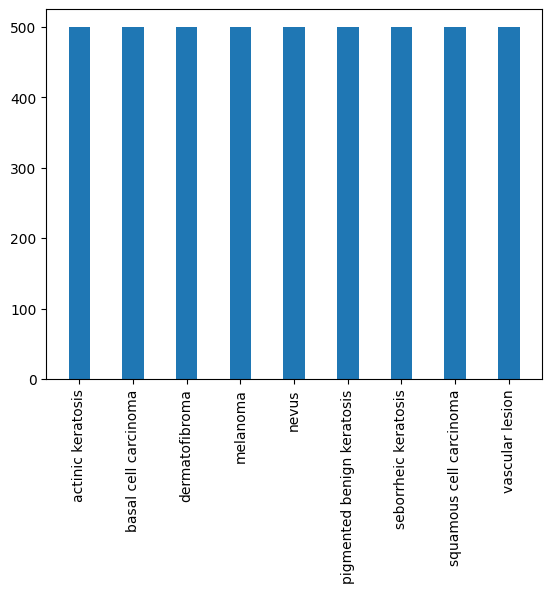

In [ ]:
data_new = df_new.groupby(by='Label').agg('count')
data_new['Label'] = data_new.index
plt.xticks(rotation=90)
plt.bar(data_new['Label'], data_new['Path'], width=0.4)

In [ ]:
df_new['Label'].value_counts()

pigmented benign keratosis    500
actinic keratosis             500
seborrheic keratosis          500
basal cell carcinoma          500
squamous cell carcinoma       500
dermatofibroma                500
melanoma                      500
nevus                         500
vascular lesion               500
Name: Label, dtype: int64

## 5. Training with a new Dataset including the Augmented Images

### 5.1 Reading Data for Training

In [ ]:
new_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

new_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
print('New Images in Train:', len(new_train_ds.file_paths))
print('New Images in Validation:', len(new_val_ds.file_paths))

class_names = new_train_ds.class_names
print('The Class Names are: ', class_names)

New Images in Train: 5392
New Images in Validation: 1347
The Class Names are:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
new_train_ds = new_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
new_val_ds = new_val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### 5.1. Training using Model 2

In [ ]:
model_2 = get_model()
model_2.build(new_train_ds.as_numpy_iterator().next()[0].shape)

In [ ]:
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 179, 179, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 178, 178, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)     

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, weight_decay=1e-6)
model_2.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
new_hist_2 = model_2.fit(new_train_ds, epochs = epochs, validation_data = new_val_ds)

Epoch 1/20
169/169 [==============================] - 42s 242ms/step - loss: 2.1559 - accuracy: 0.1712 - val_loss: 2.1207 - val_accuracy: 0.1752
Epoch 2/20
169/169 [==============================] - 32s 189ms/step - loss: 2.0411 - accuracy: 0.2264 - val_loss: 1.9640 - val_accuracy: 0.2769
Epoch 3/20
169/169 [==============================] - 32s 187ms/step - loss: 1.8915 - accuracy: 0.2893 - val_loss: 1.8217 - val_accuracy: 0.3140
Epoch 4/20
169/169 [==============================] - 32s 187ms/step - loss: 1.8010 - accuracy: 0.3029 - val_loss: 1.7401 - val_accuracy: 0.3163
Epoch 5/20
169/169 [==============================] - 32s 188ms/step - loss: 1.7561 - accuracy: 0.3249 - val_loss: 1.6976 - val_accuracy: 0.3497
Epoch 6/20
169/169 [==============================] - 32s 191ms/step - loss: 1.7254 - accuracy: 0.3284 - val_loss: 1.6534 - val_accuracy: 0.3675
Epoch 7/20
169/169 [==============================] - 32s 187ms/step - loss: 1.6943 - accuracy: 0.3403 - val_loss: 1.6647 - val_ac

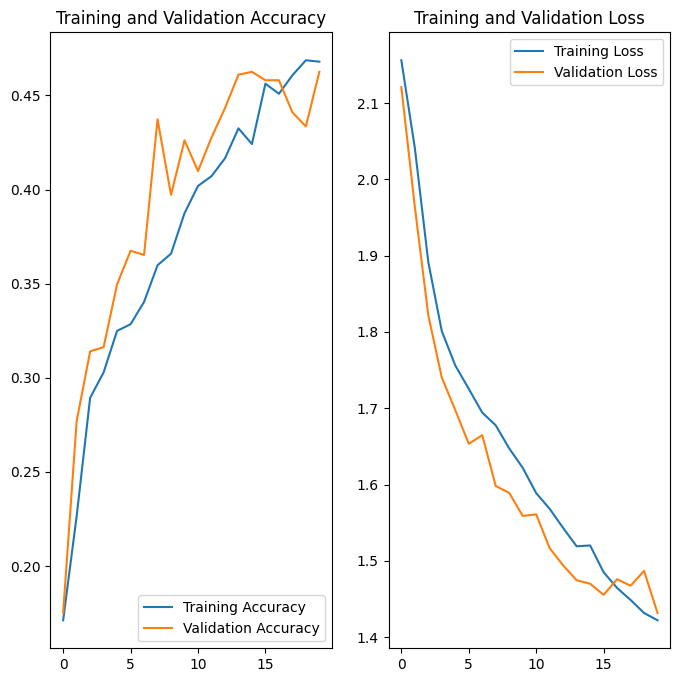

In [ ]:
visualize_outputs(new_hist_2)

- There is no change in the outcome with adding just the data. We need to adjust the layers for the model to perform better.

### 5.2. Training with Model 3
- Using BatchNormalization with Dropouts

In [ ]:
def get_model_with_bn():
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1./255, input_shape=(input_image_height, input_image_width, 3)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(Dropout(0.25))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(class_names), activation='softmax'))
    return model

In [ ]:
model_3 = get_model_with_bn()
model_3.build(new_train_ds.as_numpy_iterator().next()[0].shape)
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 179, 179, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 178, 178, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 178, 178, 64)     

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, weight_decay=1e-6)
model_3.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
new_hist_3 = model_3.fit(new_train_ds, epochs = epochs, validation_data = new_val_ds)

Epoch 1/20
169/169 [==============================] - 40s 230ms/step - loss: 2.2136 - accuracy: 0.1550 - val_loss: 2.1874 - val_accuracy: 0.1581
Epoch 2/20
169/169 [==============================] - 38s 225ms/step - loss: 2.1878 - accuracy: 0.1508 - val_loss: 2.6488 - val_accuracy: 0.1128
Epoch 3/20
169/169 [==============================] - 39s 232ms/step - loss: 2.1486 - accuracy: 0.1686 - val_loss: 5.0295 - val_accuracy: 0.1470
Epoch 4/20
169/169 [==============================] - 39s 233ms/step - loss: 2.1338 - accuracy: 0.1725 - val_loss: 7.4568 - val_accuracy: 0.1448
Epoch 5/20
169/169 [==============================] - 38s 228ms/step - loss: 2.1143 - accuracy: 0.1803 - val_loss: 11.4430 - val_accuracy: 0.1685
Epoch 6/20
169/169 [==============================] - 38s 228ms/step - loss: 2.0972 - accuracy: 0.1823 - val_loss: 8.5643 - val_accuracy: 0.1715
Epoch 7/20
169/169 [==============================] - 38s 228ms/step - loss: 2.0848 - accuracy: 0.1892 - val_loss: 7.0322 - val_a

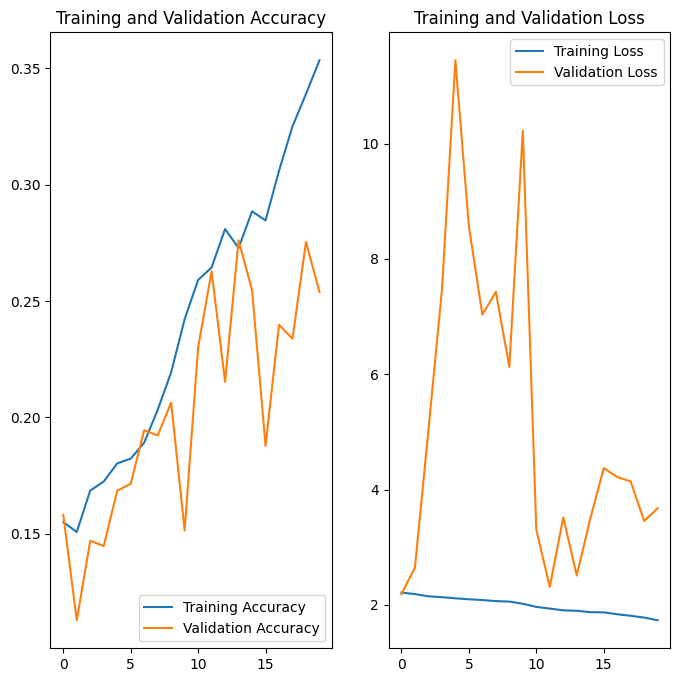

In [ ]:
visualize_outputs(new_hist_3)

- Model 3 is not working as desired and has very poor accuracy and loss metrics.

### 5.3. Training with Model 4
- Using L2 Regularization

In [ ]:
def get_model_with_Dropouts_and_regularization():
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1./255, input_shape=(input_image_height, input_image_width, 3)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dropout(0.15))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128))
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dense(len(class_names), activation='softmax'))
    return model

In [ ]:
model_4 = get_model_with_Dropouts_and_regularization()
model_4.build(new_train_ds.as_numpy_iterator().next()[0].shape)

print(model_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 179, 179, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 178, 178, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)     

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, weight_decay=1e-6)
model_4.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Epoch 1/20
169/169 [==============================] - 39s 224ms/step - loss: 3.4667 - accuracy: 0.1326 - val_loss: 3.4619 - val_accuracy: 0.1923
Epoch 2/20
169/169 [==============================] - 38s 223ms/step - loss: 3.4438 - accuracy: 0.1758 - val_loss: 3.4337 - val_accuracy: 0.1767
Epoch 3/20
169/169 [==============================] - 38s 223ms/step - loss: 3.4037 - accuracy: 0.2044 - val_loss: 3.3770 - val_accuracy: 0.2123
Epoch 4/20
169/169 [==============================] - 38s 223ms/step - loss: 3.3278 - accuracy: 0.2298 - val_loss: 3.2795 - val_accuracy: 0.2138
Epoch 5/20
169/169 [==============================] - 38s 223ms/step - loss: 3.1869 - accuracy: 0.2697 - val_loss: 3.0921 - val_accuracy: 0.3036
Epoch 6/20
169/169 [==============================] - 38s 223ms/step - loss: 3.0697 - accuracy: 0.2960 - val_loss: 3.0624 - val_accuracy: 0.3036
Epoch 7/20
169/169 [==============================] - 38s 223ms/step - loss: 2.9854 - accuracy: 0.3268 - val_loss: 2.9326 - val_ac

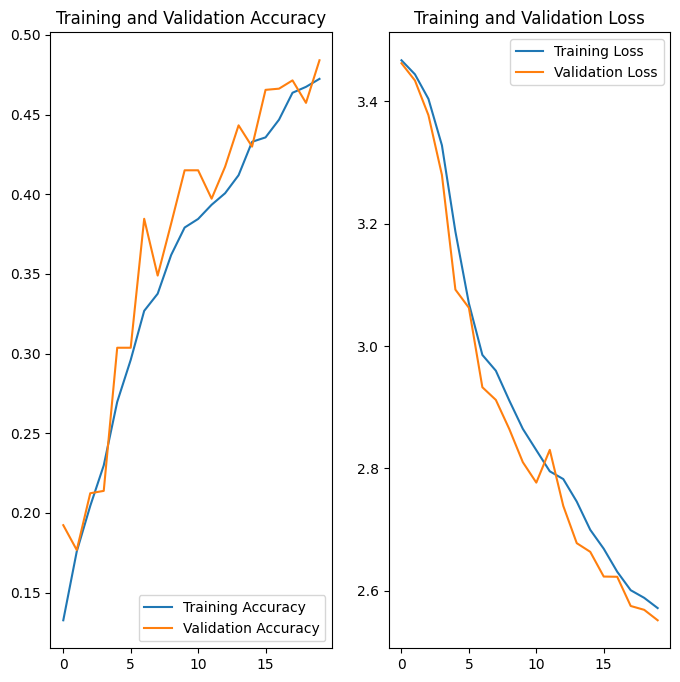

In [ ]:
new_hist_4 = model_4.fit(new_train_ds, epochs = epochs, validation_data=new_val_ds)

visualize_outputs(new_hist_4)

- This version of model has given better handling of overfitting. However, as the training and validation curves are almost matching, we can experiment to train the model for a few more epochs and aim for better accuracy.

### 5.4. Training with Model 5 ( = Model 4 + 30 epochs)

In [ ]:
model_5 = get_model_with_Dropouts_and_regularization()
model_5.build(new_train_ds.as_numpy_iterator().next()[0].shape)

print(model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 179, 179, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 178, 178, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)     

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)
model_5.compile(optimizer= optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [49]:
epochs = 30
new_hist_5 = model_5.fit(new_train_ds, epochs = epochs, validation_data=new_val_ds)

Epoch 1/30
169/169 [==============================] - 38s 216ms/step - loss: 3.4681 - accuracy: 0.1352 - val_loss: 3.4753 - val_accuracy: 0.1359
Epoch 2/30
169/169 [==============================] - 36s 212ms/step - loss: 3.4580 - accuracy: 0.1575 - val_loss: 3.4660 - val_accuracy: 0.1210
Epoch 3/30
169/169 [==============================] - 36s 211ms/step - loss: 3.4489 - accuracy: 0.1552 - val_loss: 3.4540 - val_accuracy: 0.1403
Epoch 4/30
169/169 [==============================] - 37s 217ms/step - loss: 3.4381 - accuracy: 0.1736 - val_loss: 3.4496 - val_accuracy: 0.1537
Epoch 5/30
169/169 [==============================] - 37s 216ms/step - loss: 3.4264 - accuracy: 0.1760 - val_loss: 3.4323 - val_accuracy: 0.1915
Epoch 6/30
169/169 [==============================] - 36s 211ms/step - loss: 3.4153 - accuracy: 0.2014 - val_loss: 3.4137 - val_accuracy: 0.2153
Epoch 7/30
169/169 [==============================] - 36s 212ms/step - loss: 3.4009 - accuracy: 0.2020 - val_loss: 3.4018 - val_ac

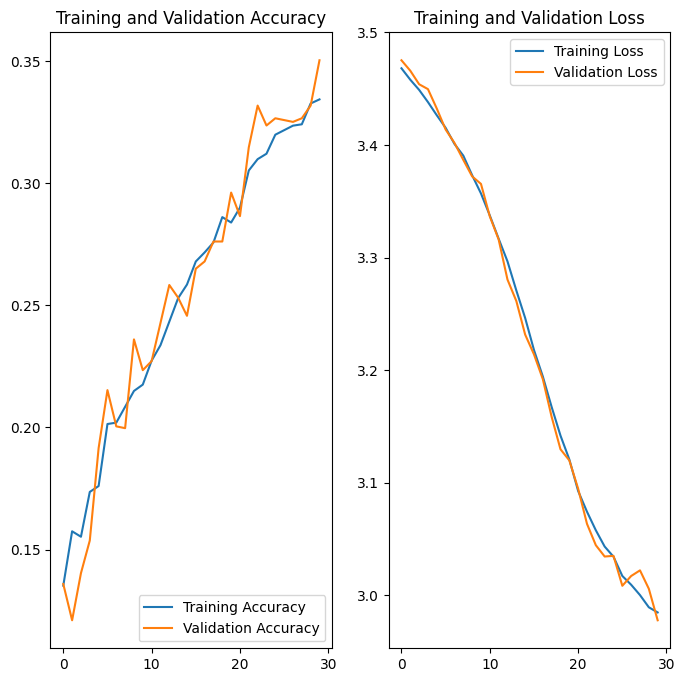

In [50]:
epochs = 30
visualize_outputs(new_hist_5)

- The model resulted in a proper handling of overfitting.. However, due to low learning rate, the model accuracy is impacted. Let's increase the learning rate and epochs

### 5.5. Training with Model 6 ( = Model 4 + 50 epochs + )

In [54]:
epochs = 50
model_6 = get_model_with_Dropouts_and_regularization()
model_6.build(new_train_ds.as_numpy_iterator().next()[0].shape)

print(model_6.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 179, 179, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 178, 178, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)     

In [55]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_6.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [56]:
new_hist_6 = model_6.fit(new_train_ds, epochs = epochs, validation_data=new_val_ds)

Epoch 1/50
169/169 [==============================] - 36s 207ms/step - loss: 3.4287 - accuracy: 0.1554 - val_loss: 3.3757 - val_accuracy: 0.2190
Epoch 2/50
169/169 [==============================] - 35s 208ms/step - loss: 3.1869 - accuracy: 0.2211 - val_loss: 3.0731 - val_accuracy: 0.2294
Epoch 3/50
169/169 [==============================] - 37s 216ms/step - loss: 2.9395 - accuracy: 0.2774 - val_loss: 2.9746 - val_accuracy: 0.2554
Epoch 4/50
169/169 [==============================] - 36s 210ms/step - loss: 2.7833 - accuracy: 0.3155 - val_loss: 2.6163 - val_accuracy: 0.3727
Epoch 5/50
169/169 [==============================] - 36s 211ms/step - loss: 2.6167 - accuracy: 0.3629 - val_loss: 2.5085 - val_accuracy: 0.3883
Epoch 6/50
169/169 [==============================] - 36s 211ms/step - loss: 2.5809 - accuracy: 0.3492 - val_loss: 2.4866 - val_accuracy: 0.3890
Epoch 7/50
169/169 [==============================] - 36s 215ms/step - loss: 2.4008 - accuracy: 0.4138 - val_loss: 2.3032 - val_ac

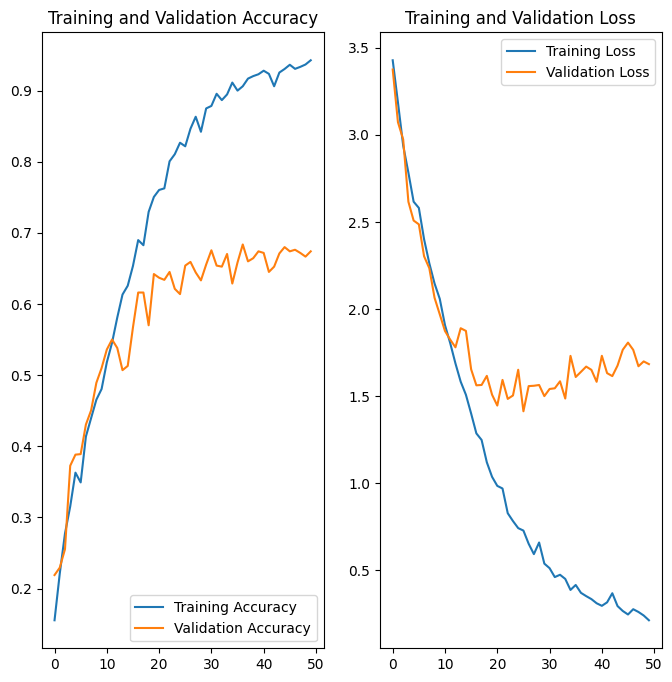

In [57]:
visualize_outputs(new_hist_6)

**Observations**
- We observe that the model didn't show any signs of overfitting till epoch 20-25. However, upon larger epochs, the problem of overfitting seems re-surfaced.
- Hence, we can limit the epochs to ~25 for a better model

## 6. Testing

In [58]:
final_model = model_6

In [59]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
          testing_data_dir,
          labels='inferred', seed=123,
          validation_split=None,
          subset=None,
          label_mode='categorical',
          image_size=(input_image_height, input_image_width),
          batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [60]:
print("Testing Dataset ClassNames: ", test_ds.class_names)

Testing Dataset ClassNames:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [61]:
test_predictions = final_model.predict(test_ds, batch_size=batch_size, workers=4)

4/4 [==============================] - 35s 396ms/step


In [62]:
unbatched_data = test_ds.unbatch()

In [63]:
actual_test_labels = [np.argmax(label) for image, label in unbatched_data.as_numpy_iterator()]
predicted_test_labels = np.argmax(test_predictions, axis=1)

In [64]:
testing_results = pd.DataFrame({'actual': actual_test_labels})

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Testing data Accuracy score:", accuracy_score(actual_test_labels, predicted_test_labels))

Testing data Accuracy score: 0.1864406779661017


In [67]:
models = [model_1, model_2, model_3, model_4, model_5, model_6]
i = 1
for each_model in models:
  predicted_results = np.argmax(each_model.predict(test_ds, batch_size=batch_size, workers=8), axis=1)
  print("Testing data Accuracy score with model", i, ":", accuracy_score(actual_test_labels, predicted_results))
  i = i + 1


4/4 [==============================] - 9s 51ms/step
Testing data Accuracy score with model 1 : 0.1864406779661017
4/4 [==============================] - 4s 50ms/step
Testing data Accuracy score with model 2 : 0.11016949152542373
4/4 [==============================] - 6s 50ms/step
Testing data Accuracy score with model 3 : 0.11864406779661017
4/4 [==============================] - 4s 50ms/step
Testing data Accuracy score with model 4 : 0.1271186440677966
4/4 [==============================] - 5s 50ms/step
Testing data Accuracy score with model 5 : 0.1271186440677966
4/4 [==============================] - 5s 50ms/step
Testing data Accuracy score with model 6 : 0.13559322033898305
